# Angle Recovery with Perfect Distances

In this phase we will try to do angle recovery assuming we know the prefect distances.

The optimization equation looks like this:
\begin{equation}
\label{eq:phase1}
{\{\hat{q_i}\}_{i=1}^N} = \operatorname*{arg\,min}_{\{\hat{q}_i\}_{i=1}^N} \sum_{i,j} \left| d_q(q_i, q_j) - d_q(\hat{q_i}, \hat{q_j}) \right|^2
\end{equation}

We start by random uniform distribution of angle triplets corresponding to the quaternion values $\hat{q_i}$ and $\hat{q_j}$ and we want to see if during the optimization we manage to estimate the true quaternions $q_i$ and $q_j$.


## Content

In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import os
import h5py
import numpy as np
from IPython.display import Image
import ipyvolume as ipv
import tensorflow as tf

import sys
sys.path.append("../..") 
from cryoem.plots import (plot_angles_count, plot_euclidean_space, save_space_plot,
                        plot_selected_angles_with_3rd_angle_magnitude, 
                        plot_dP_dQ,plot_only_selected_in_euclidean_space, 
                        plot_rays, plot_images, plot_angles_with_3rd_angle_magnitude, plot_distances_count,
                         plot_iterations_polar_plot, plot_iterations_rotvec, plot_rotvec, plot_polar_plot)
from cryoem.conversions import d_q, quaternion2euler, euler2quaternion, distance_difference
from cryoem.angle_alignment import training_angle_alignment,update_quaternion
from cryoem.angle_recovery import train_angle_recovery
import seaborn as sns; sns.set(style="white", color_codes=True)
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10909325674640496447
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2743782780376430971
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6500500873184021636
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15465516470460656914
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 106102784
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 4940738219295124216
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:3b:00.0, compute capability: 3.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_l

---

## 1. Symmetric Protein (5A1A)

Data used:
- Protein: 5a1a (symmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5a1a.pdb1-500.jpg)

---

# 1.2. Data Preparation

In [3]:
PROTEIN="5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage0.9,1.0,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (275, 275) pixels
5000 sets of 3 ground truth angles of corresponding projection images


#### Projections

In [4]:
projections = data['Projections']

#### True Angles

(5000, 3)


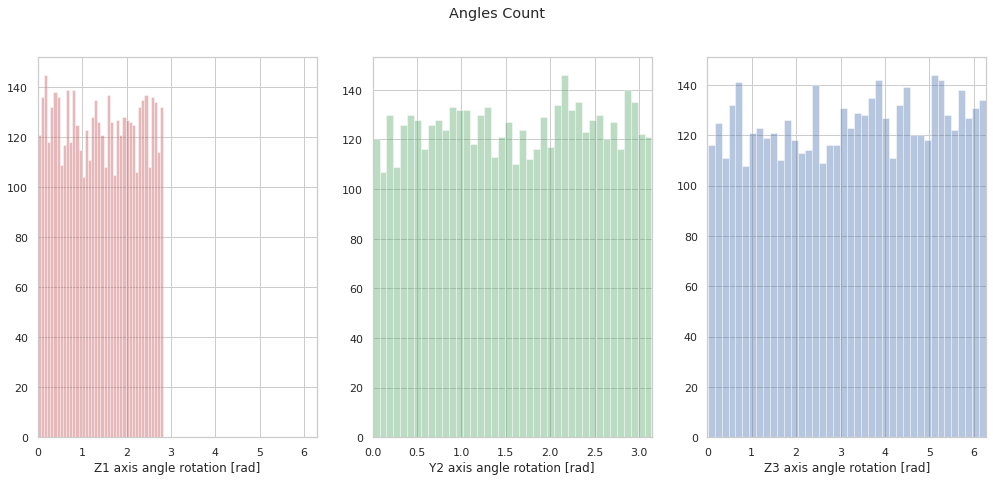

In [5]:
angles_true = np.array(data['Angles'])
print(angles_true.shape)
plot_angles_count(angles_true)

In [6]:
arr_true = R.from_euler('zyz', angles_true).as_rotvec()
a = arr_true

ipv.figure()
ipv.scatter(a[:,0], a[:,1], a[:,2], marker="sphere", color="red", size=1)
ipv.xlim(-np.pi, np.pi);ipv.ylim(-np.pi, np.pi);ipv.zlim(-np.pi, np.pi);
ipv.show()

In [24]:
ipv.screenshot()

Output()

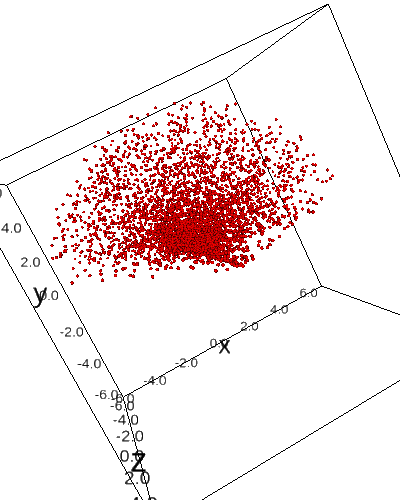

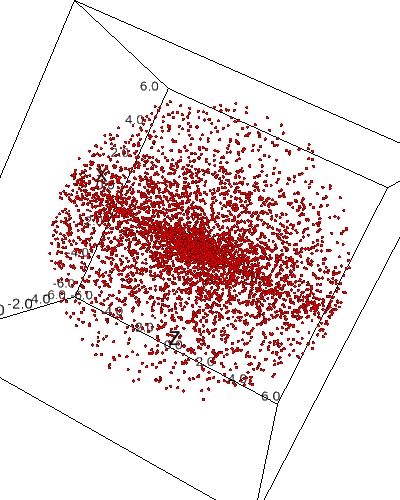

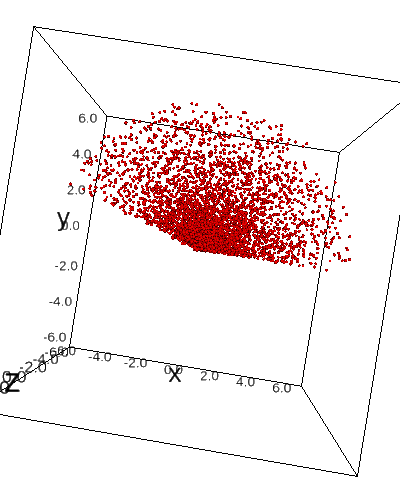

In [60]:
z0, y1, z1 = angles_true[:,0], angles_true[:,1], angles_true[:,2]

ipv.clear()
x = z1*np.sin(y1)*np.cos(z0)
y = z1*np.sin(y1)*np.sin(z0)
z = z1*np.cos(y1)


ipv.scatter(x, y, z, marker="sphere", color="red", size=1)
ipv.xlim(-2*np.pi, 2*np.pi);ipv.ylim(-2*np.pi, 2*np.pi);ipv.zlim(-2*np.pi, 2*np.pi);
ipv.show()


In [63]:
ipv.screenshot()

Output()

---

# 1.3. Experiments

## 1.3.1. Angle Recovery: Perfect Distance

#### dP/dQ plot

In [7]:
def d_p(in1, in2):
    return d_q(in1, in2)

In [29]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

<Figure size 432x288 with 0 Axes>

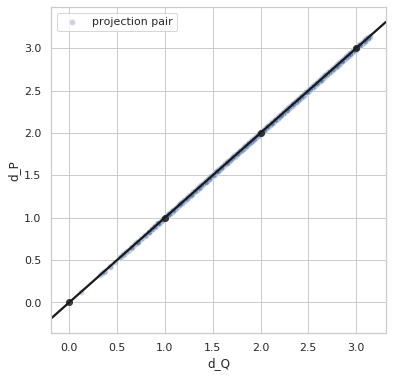

<Figure size 432x288 with 0 Axes>

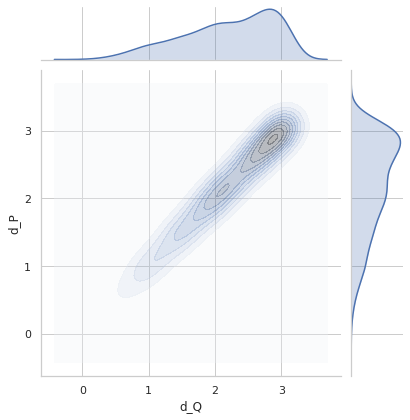

In [30]:
plot_dP_dQ(dP_values, dQ_values);
plot_dP_dQ_density(dP_values, dQ_values);

In [31]:
# variance
np.sqrt(1/(len(dQ_values)-1)*np.sum(np.power(dP_values-dQ_values, 2)))

0.0

#### Angle Recovery

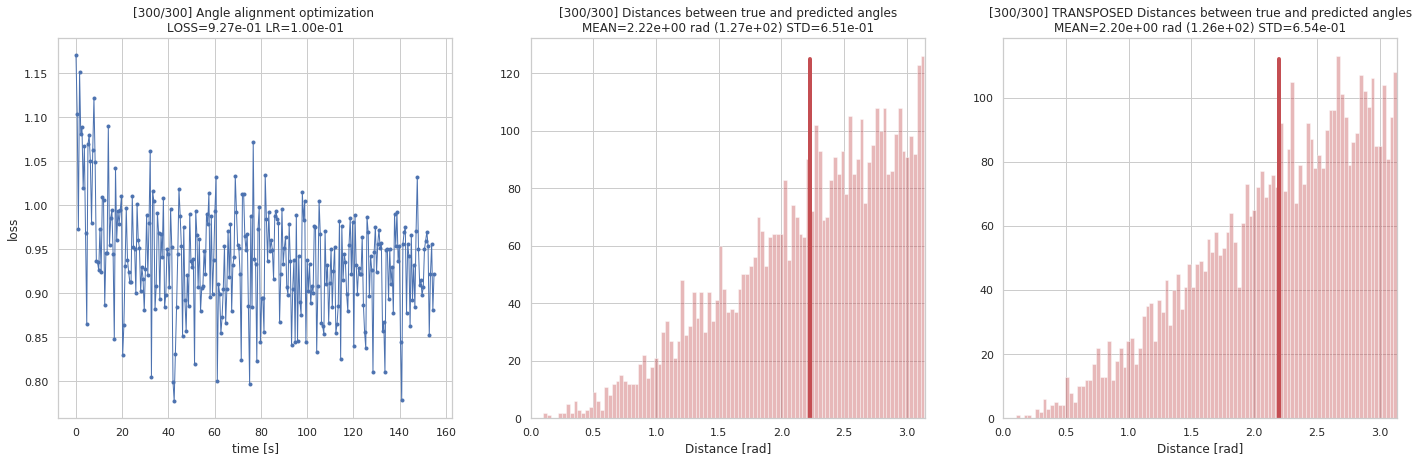

Shape of projections: (5000, 4)step 30/300 (31s): loss = 9.86e-01
step 60/300 (45s): loss = 9.88e-01
step 90/300 (59s): loss = 8.52e-01
step 120/300 (72s): loss = 9.11e-01
step 150/300 (86s): loss = 9.38e-01
step 180/300 (100s): loss = 9.36e-01
step 210/300 (114s): loss = 9.10e-01
step 240/300 (128s): loss = 9.64e-01
step 270/300 (142s): loss = 9.37e-01
step 300/300 (156s): loss = 9.22e-01



In [10]:
losses, q_predicted, arrp = train_angle_recovery(steps=300, 
                                 batch_size=512, 
                                 in_data=angles_true, 
                                 distance_fn=d_p, 
                                 learning_rate=0.1,
                                angles_true=angles_true,
                                 optimization=True)

In [52]:
%matplotlib inline
from scipy.spatial.transform import Rotation as R

arr2 = R.from_euler('zyz', angles_true).as_rotvec()

ipv.figure()
s = ipv.scatter(arrp[:, :,0], arrp[:, :,1], arrp[:, :,2], marker="sphere", color="blue", size=1)
ipv.scatter(arr2[:,0], arr2[:,1], arr2[:,2], marker="sphere", color="red", size=1)
ipv.animation_control(s, interval=1)
ipv.show()

In [51]:
ipv.screenshot()

Output()

In [40]:
# q_save = np.zeros((len(q_predicted),4))
# for i, q in enumerate(q_predicted):
#     q_save[i] = q.numpy()
                    
# np.save("data/5a1a/predicted_quaternions.npy2", q_save)

In [38]:
# Image(filename='../3-reconstruction/data/5a1a_projections_and_angles_predicted.png')

## Angle Alignment

In [55]:
def angles_transpose(angles):
    angles[:,[0, 2]] = angles[:,[2, 0]]
    angles *= -1
    return angles

In [56]:
qp = np.load("data/5a1a/predicted_quaternions2.npy")

transposed = False
ap = quaternion2euler(qp)
ap = angles_transpose(ap.numpy())

np.save("data/5a1a/predicted_angles.npy", ap)

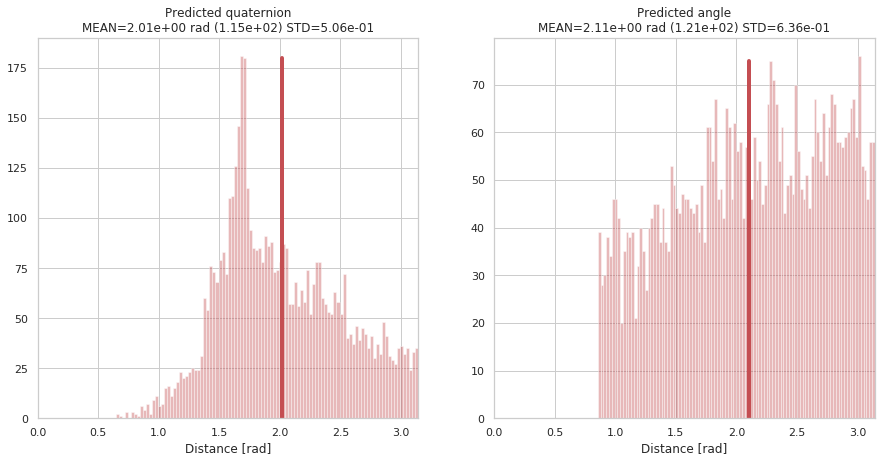

In [57]:
# check: both plots should be the same (if transposed=False)
fig, axs = plt.subplots(1, 2, figsize=(15,7))
d2 = d_q(euler2quaternion(angles_true), qp)
axs[0].set_xlim(0, np.pi)
axs[0].set_title(f"Predicted quaternion\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
s = sns.distplot(d2, kde=False, bins=100, ax=axs[0], axlabel="Distance [rad]", color="r")
max_count = int(max([h.get_height() for h in s.patches]))
axs[0].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

d3 = d_q(euler2quaternion(angles_true), euler2quaternion(ap))
axs[1].set_xlim(0, np.pi)
axs[1].set_title(f"Predicted angle\nMEAN={np.mean(d3):.2e} rad ({np.degrees(np.mean(d3)):.2e}) STD={np.std(d3):.2e}")
s = sns.distplot(d3, kde=False, bins=100, ax=axs[1], axlabel="Distance [rad]", color="r")
max_count = int(max([h.get_height() for h in s.patches]))
axs[1].plot([np.mean(d3)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

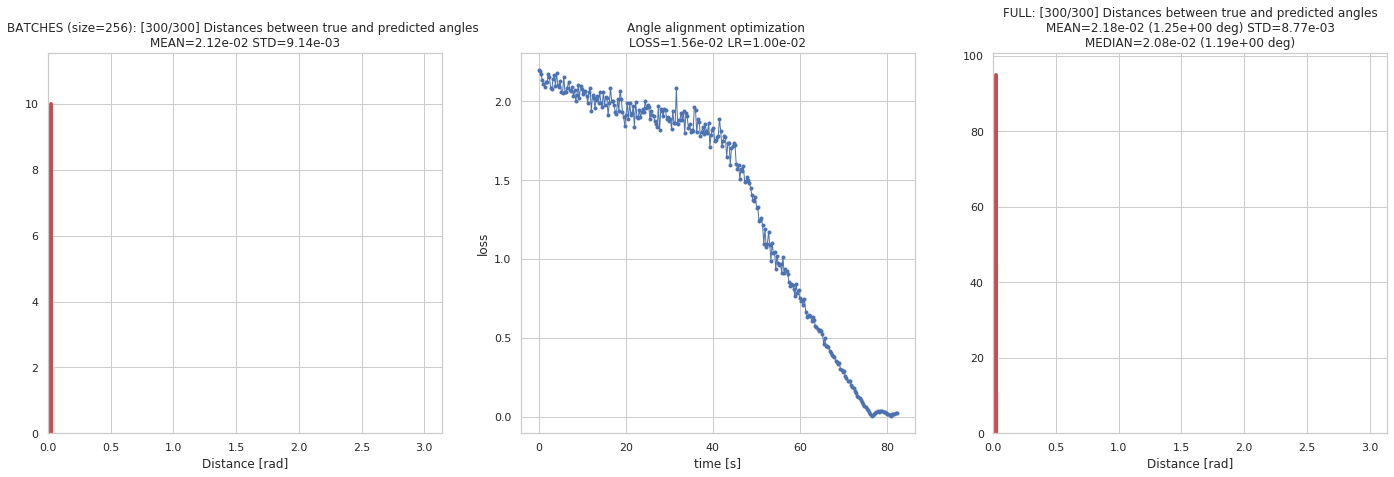

step 30/300 (9s): loss = 2.12e+00
step 60/300 (17s): loss = 2.03e+00
step 90/300 (26s): loss = 1.95e+00
step 120/300 (34s): loss = 1.91e+00
step 150/300 (43s): loss = 1.84e+00
step 180/300 (51s): loss = 1.64e+00
step 210/300 (59s): loss = 1.09e+00
step 240/300 (67s): loss = 6.75e-01
step 270/300 (76s): loss = 2.86e-01
step 300/300 (84s): loss = 3.07e-02



In [66]:
m, rotation, loss, arr = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                             steps=300, 
                                             batch_size=256, 
                                             projection_idx=range(NUM_PROJECTIONS), 
                                             learning_rate=0.01, 
                                             angles_true=angles_true, 
                                             angles_predicted=ap)

In [67]:
m, rotation[0].numpy(), loss[-1]

([1.0, 1.0, 1.0, 1.0],
 array([7.75002656, 0.3007453 , 6.15445275, 0.98073965, 3.15953732,
        5.46325849]),
 0.02073006861499844)

In [68]:
arr = np.array(arr)

In [69]:
from scipy.spatial.transform import Rotation as R

arr2 = R.from_euler('zyz', angles_true).as_rotvec()

ipv.figure()
s = ipv.scatter(arr[:, :,0], arr[:, :,1], arr[:, :,2], marker="sphere", color="blue", size=1)
ipv.scatter(arr2[:,0], arr2[:,1], arr2[:,2], marker="sphere", color="red", size=1)
ipv.animation_control(s, interval=200)
ipv.show()

In [50]:
qpn = euler2quaternion(ap)

qpa = update_quaternion(m=m, 
                        a_R=rotation, 
                        q_predicted=qpn)

angles_predicted = quaternion2euler(qpa).numpy()

np.save("data/5a1a/predicted_angles_updated.npy", angles_predicted)

In [30]:
# Image(filename='../3-reconstruction/data/5a1a_projections_and_angles_predicted_updated.png')

---

# 2. Asymmetric Protein (5J0N)

Data used:
- Protein: 5j0n (asymmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5j0n.pdb1-500.jpg)

---

# 2.2. Data Preparation

In [4]:
PROTEIN="5j0n"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


#### Projections

In [5]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

#### True Angles

(5000, 3)


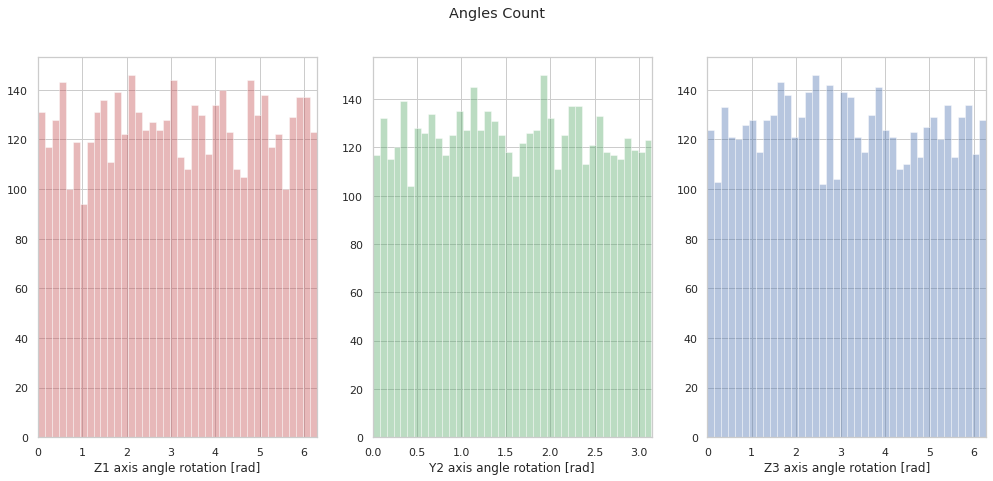

In [6]:
angles_true = np.array(data['Angles'])
print(angles_true.shape)
plot_angles_count(angles_true)

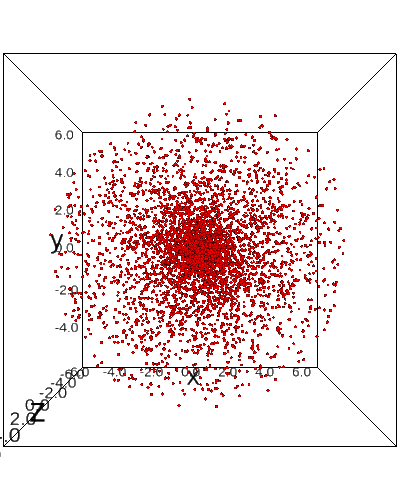

In [7]:
plot_polar_plot(angles_true);

In [8]:
ipv.screenshot()

Output()

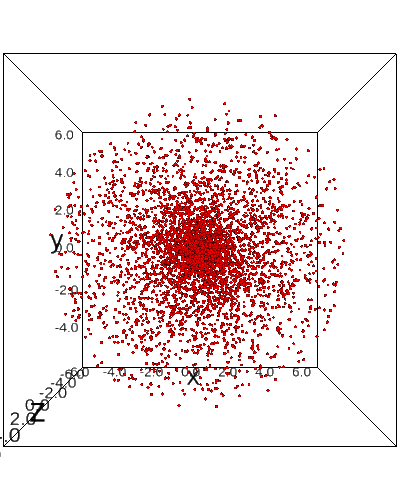

In [9]:
plot_polar_plot(angles_true)

In [10]:
ipv.screenshot()

Output()

---

# 2.3. Experiments

## 2.3.1. Angle Recovery: Perfect Distance

#### dP/dQ plot

In [7]:
def d_p(in1, in2):
    return d_q(in1, in2)

In [8]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

<Figure size 432x288 with 0 Axes>

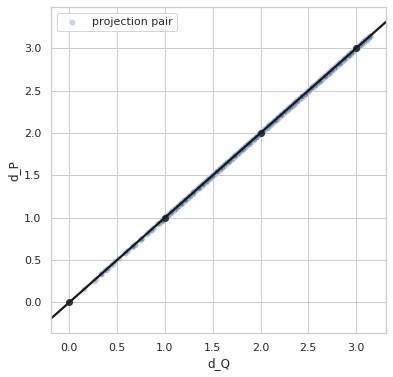

<Figure size 432x288 with 0 Axes>

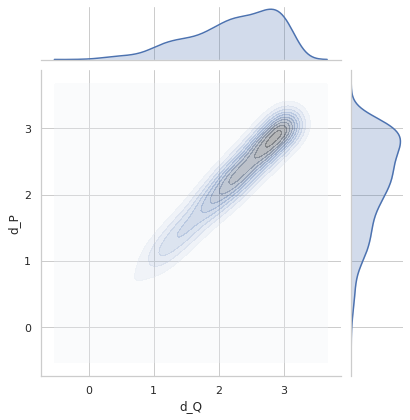

Variance = 0.0
Min. angle recovery loss possible = 0.0


In [9]:
plot_dP_dQ(dP_values, dQ_values);

## Angle Recovery

In [13]:
# from cryoem.angle_recovery import angles_transpose

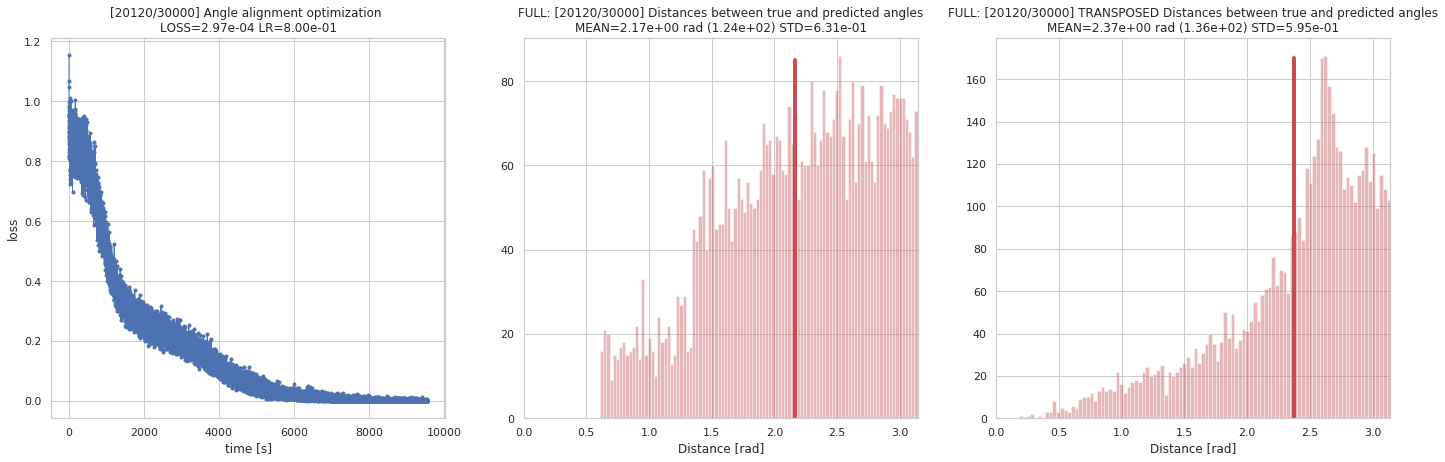

Shape of projections: (5000, 4)step 3000/30000 (1369s): loss = 3.63e-01
step 6000/30000 (2723s): loss = 1.81e-01
step 9000/30000 (4116s): loss = 1.06e-01
step 12000/30000 (5578s): loss = 2.10e-02
step 15000/30000 (7048s): loss = 2.47e-03
step 18000/30000 (8508s): loss = 2.44e-04
step 20120/30000 (9549s): loss = 1.27e-04



In [13]:
q_predicted, losses, q_all = train_angle_recovery(steps=30000, 
                                                   batch_size=512, 
                                                   in_data=angles_true, 
                                                   distance_fn=d_p, 
                                                   learning_rate=0.8, #0.1, 
                                                   angles_true=angles_true,
                                                   optimization=True)

In [23]:
np.save("data/5j0n/predicted_quaternions_full_losses.npy",     losses)
np.save("data/5j0n/predicted_quaternions_full_iterations.npy", q_all)
np.save("data/5j0n/predicted_quaternions_full.npy",            q_predicted.numpy())

##### Plots

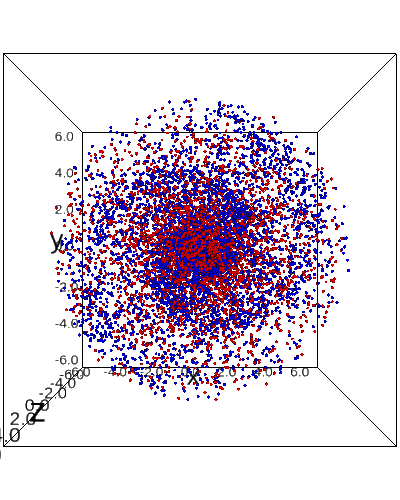

In [14]:
plot_iterations_polar_plot(q_all, angles_true);

In [15]:
ipv.screenshot()

Output()

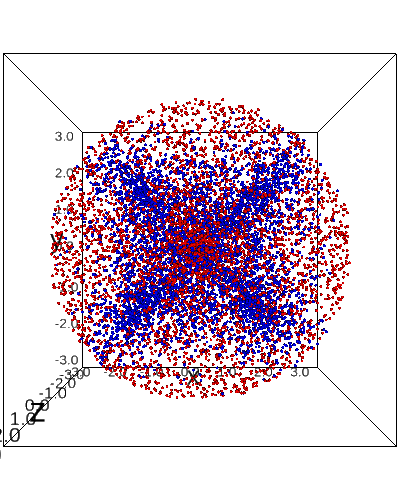

In [12]:
plot_iterations_rotvec(q_all, angles_true);

In [13]:
ipv.screenshot()

Output()

In [29]:
# Image(filename='../3-reconstruction/data/5j0n_projections_and_angles_predicted.png')

# Angle Alignment

#### Prediction angles from previous phase that we want to align with true angles

In [51]:
losses      = np.load("data/5j0n/predicted_quaternions_full_losses.npy")
q_all       = np.load("data/5j0n/predicted_quaternions_full_iterations.npy")
q_predicted = np.load("data/5j0n/predicted_quaternions_full.npy")

In [52]:
angles_predicted = quaternion2euler(q_predicted).numpy()%(2*np.pi)

In [53]:
np.save("data/5j0n/predicted_angles_full.npy", angles_predicted)

---

#### Run the Optimization

The `rotation` is our minimizer and we initialize this 6D vector with random values. That is the reason the optimization sometimes converges to 0 loss and sometimes not.

In [54]:
from cryoem.angle_alignment import training_angle_alignment

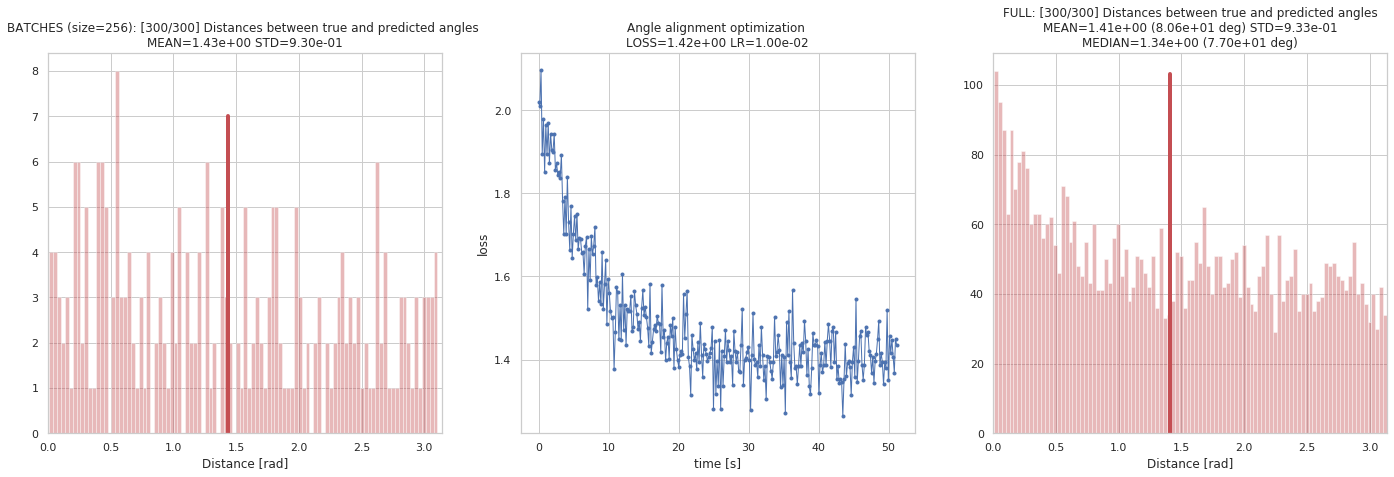

step 30/300 (6s): loss = 1.86e+00
step 60/300 (11s): loss = 1.63e+00
step 90/300 (16s): loss = 1.51e+00
step 120/300 (21s): loss = 1.46e+00
step 150/300 (26s): loss = 1.42e+00
step 180/300 (31s): loss = 1.40e+00
step 210/300 (37s): loss = 1.40e+00
step 240/300 (42s): loss = 1.41e+00
step 270/300 (47s): loss = 1.40e+00
step 300/300 (52s): loss = 1.41e+00

---


In [55]:
m, rotation, loss, collect_data  = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                                 steps=300, 
                                                 batch_size=256, 
                                                 learning_rate=0.01, 
                                                 angles_true=angles_true, 
                                                 angles_predicted=angles_predicted)

In [56]:
m, rotation[0].numpy()

([1.0, 1.0, 1.0, 1.0],
 array([3.29364894, 2.72447373, 3.1513046 , 2.03657162, 3.24079399,
        1.48732577]))

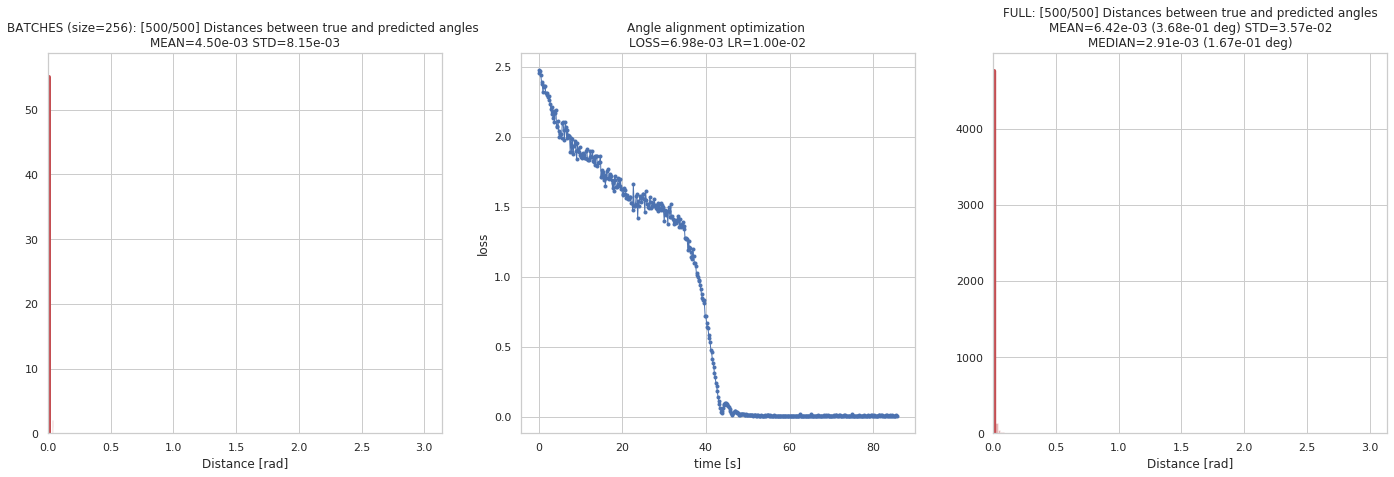

step 50/500 (10s): loss = 2.16e+00
step 100/500 (19s): loss = 1.83e+00
step 150/500 (27s): loss = 1.60e+00
step 200/500 (36s): loss = 1.47e+00
step 250/500 (44s): loss = 8.93e-01
step 300/500 (53s): loss = 3.95e-02
step 350/500 (62s): loss = 7.37e-03
step 400/500 (70s): loss = 6.48e-03
step 450/500 (79s): loss = 7.49e-03
step 500/500 (87s): loss = 7.52e-03

---


In [59]:
m, rotation, loss, collect_data  = training_angle_alignment(m=[-1.0, 1.0, 1.0, 1.0],
                                                 steps=500, 
                                                 batch_size=256, 
                                                 learning_rate=0.01, 
                                                 angles_true=angles_true, 
                                                 angles_predicted=angles_predicted)

In [60]:
m, rotation[0].numpy()

([-1.0, 1.0, 1.0, 1.0],
 array([4.41976714, 3.55745135, 3.1409189 , 2.03366073, 3.24626458,
        1.48535892]))

##### Plots

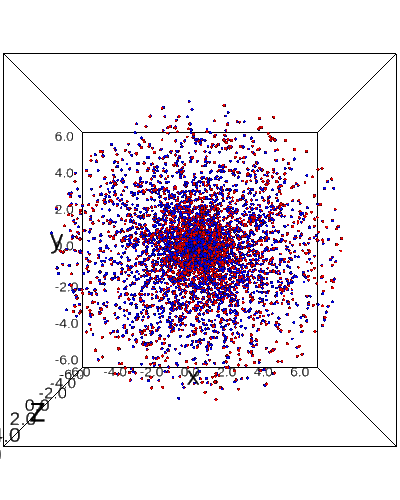

In [28]:
plot_iterations_polar_plot(collect_data, angles_true);

In [29]:
ipv.screenshot()

Output()

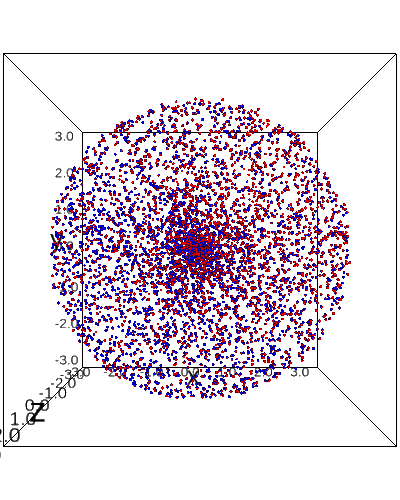

In [30]:
plot_iterations_rotvec(collect_data, angles_true);

In [31]:
ipv.screenshot()

Output()

In [32]:
qpn = euler2quaternion(angles_predicted)

qpa = update_quaternion(m=m, 
                        a_R=rotation, 
                        q_predicted=qpn)

angles_predicted_rotated = quaternion2euler(qpa).numpy()

np.save("data/5j0n/predicted_angles_full_updated.npy", angles_predicted_rotated)

In [51]:
# Image(filename='../3-reconstruction/data/5j0n_projections_and_angles_predicted_updated.png')